# Modeling Time!

We have a fairly good idea of what the data tells us about injuries, but now it's time to use it to tell a story about the future. Can we predict which body part will be injured? Or which position group? Let's find out. First, let's do a quick linear regression model in sci-kit learn.

In [1]:
#import necessary programs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from yellowbrick.classifier import ConfusionMatrix
import seaborn as sns
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb

In [2]:
#upload csv from analysis 
df = pd.read_csv('./data/NFL.csv')

In [3]:
df.head()
df.shape

(77, 8)

In [4]:
df.columns

Index(['StadiumType', 'FieldType', 'Temperature', 'PlayType', 'Position',
       'PositionGroup', 'BodyPart', 'days_missed'],
      dtype='object')

Both Position and PositionGroup are still in our data. Let's keep PositionGroup

In [5]:
df = df.drop(columns='Position')

### Feature Selection 

At this point out dataset is fairly small, just 77 rows of data in 8 columns. However this will change when we create dummy data for all the categorical data. Let's do that first and then begin with using random forests to identify our most important features. 

In [6]:
#Seperate target and dependents
np.random.seed(12)
X = df.drop('days_missed', axis=1)
X = pd.get_dummies(X)
y = df.days_missed

In [7]:
X.head()

,StadiumType_Dome,StadiumType_Indoor,StadiumType_Outdoor,StadiumType_Partial Outdoor,StadiumType_Retractable Roof,StadiumType_Unknown,FieldType_Natural,FieldType_Synthetic,Temperature_30-39,Temperature_40-49,...,PositionGroup_DB,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_RB,PositionGroup_TE,PositionGroup_WR,BodyPart_Ankle,BodyPart_Foot,BodyPart_Knee
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
4,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


Alright, now that we have our data set up let's perform a random forest for feature importance.  

In [8]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11, test_size=.2)

In [9]:
print(len(y_train))
len(y_test)

61


16

In [10]:
#first building a baseline decision tree
nfl_forest= nfl_for = RandomForestClassifier(n_estimators = 25, max_depth=6)
nfl_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

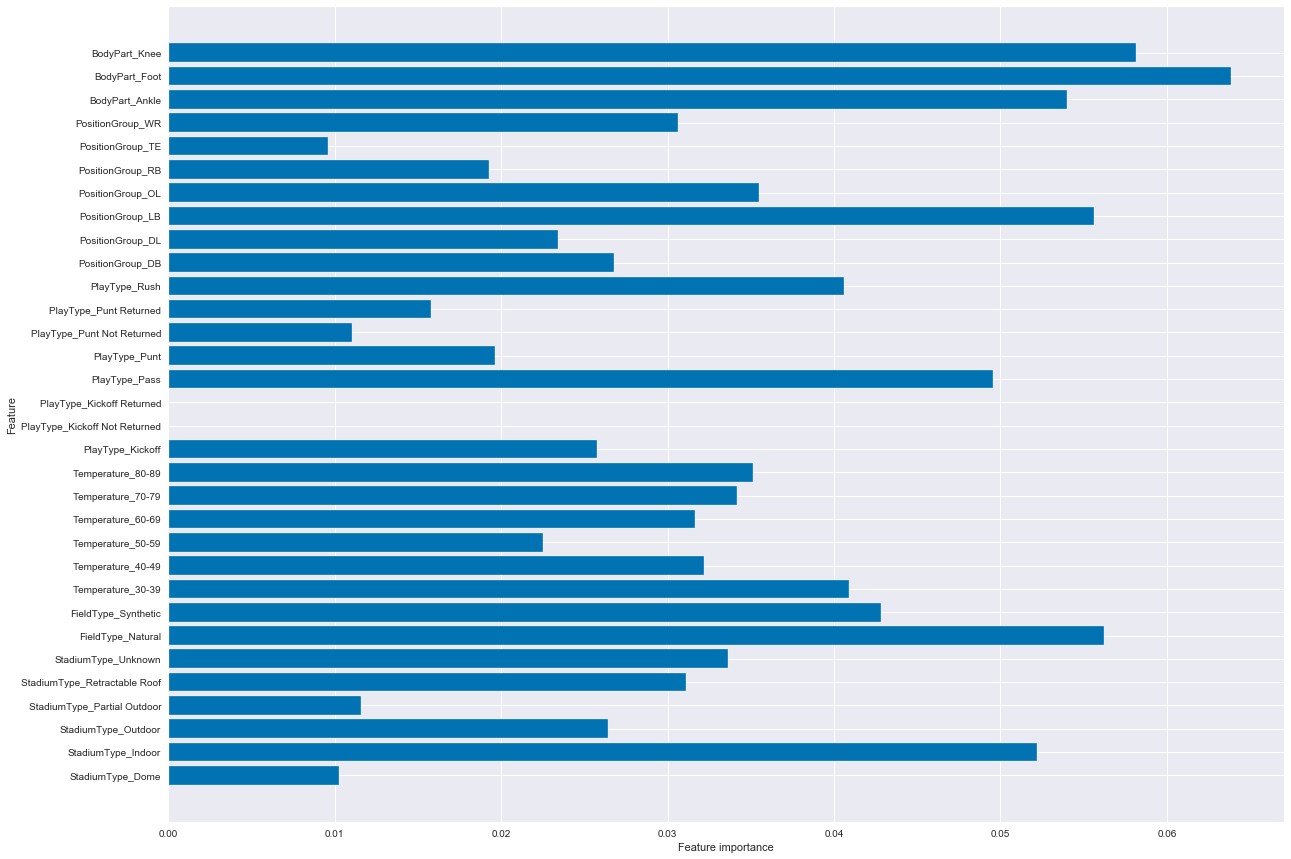

In [11]:
#feature importance 
sns.set_style('darkgrid')
colors = sns.set_palette('colorblind')

def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(20,15))
    X = range(n_features)
    plt.barh(X, model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(nfl_forest)

In [12]:
nfl_forest.feature_importances_

array([0.01024224, 0.05221962, 0.02641585, 0.0115717 , 0.03113216,
       0.03362208, 0.05621555, 0.04282037, 0.04088989, 0.03217337,
       0.02254085, 0.03165216, 0.03414973, 0.03514317, 0.02578551,
       0.        , 0.        , 0.04955702, 0.01961899, 0.0110725 ,
       0.0158008 , 0.04058953, 0.02679349, 0.02342114, 0.05562656,
       0.03548022, 0.01926865, 0.00957743, 0.03060217, 0.05400101,
       0.06385912, 0.05815714])

In [13]:
#put features in a dictionary
features = {}

for feature, importance in zip(X.columns, nfl_forest.feature_importances_):
    features[feature] = importance

In [14]:
#create dataframe with importances
nfl_importance = pd.DataFrame.from_dict(features, orient='index')

In [15]:
nfl_importance = nfl_importance.rename(columns={0:'Importance'})

In [16]:
#sort by level of importance 
nfl_importance.sort_values(by='Importance', ascending=False, inplace=True)
nfl_feats = nfl_importance.head(50).index

In [17]:
nfl_feats

Index(['BodyPart_Foot', 'BodyPart_Knee', 'FieldType_Natural',
       'PositionGroup_LB', 'BodyPart_Ankle', 'StadiumType_Indoor',
       'PlayType_Pass', 'FieldType_Synthetic', 'Temperature_30-39',
       'PlayType_Rush', 'PositionGroup_OL', 'Temperature_80-89',
       'Temperature_70-79', 'StadiumType_Unknown', 'Temperature_40-49',
       'Temperature_60-69', 'StadiumType_Retractable Roof', 'PositionGroup_WR',
       'PositionGroup_DB', 'StadiumType_Outdoor', 'PlayType_Kickoff',
       'PositionGroup_DL', 'Temperature_50-59', 'PlayType_Punt',
       'PositionGroup_RB', 'PlayType_Punt Returned',
       'StadiumType_Partial Outdoor', 'PlayType_Punt Not Returned',
       'StadiumType_Dome', 'PositionGroup_TE', 'PlayType_Kickoff Not Returned',
       'PlayType_Kickoff Returned'],
      dtype='object')

Now we've got all our features by order of importance in one place. I can easily use this to manipulate the numebr of features included in our model for accuracy. 

Let's also take a moment to make some observation about the most important features: 

1. BodyPart_Ankle
2. Temperature_80-89
3. BodyPart_Foot
4. Position_WR
5. Fieldtype_Synthetic

This is already informative. Although we can't say how accurately these things predict time missed they seem to be the most important predictors at baseline. Temperature is intersting in the number two spot - as mentioned previously this is likely more correlation with the beginning of the season but I still wouldn't have guessed it would be in this position. Also, synthetic field types rolling in at number five tells us that perhaps turf fields cause more injuries than natural field types (although in this importance ranking the natural field types comes only 4 features later). 

## Baseline 

In order to evaluate how well our model is performing, it is important to creat a baseline (a.k.a. what we might get from randomly guessing). I'll used the following formula for that. 

P(class is 0) * P(guess is 0) + P(class is 1) * P(guess is 1) + etc.

In [18]:
Baseline = ((len(y[y==1])/len(y)) * (len(y[y==1])/len(y)) + (len(y[y==2])/len(y)) * (len(y[y==2])/len(y)) + (
    len(y[y==3])/len(y)) * (len(y[y==3])/len(y)) + (len(y[y==4])/len(y)) * (len(y[y==4])/len(y))) * 100
Baseline

29.60026986001012

## Model Functions

Before beginning to model I'd like to discuss my approach. I'd like to utilize several different types of classification models (logisitic regression, Decision Tree, KNN, and random forest and compare their accuracy with various numbers of featured included. 

The first step below is to create functions for these models so they are easily used later. To do this I'll create a Pipeline that includes all the models I would like to explore. 

In [19]:
#first create several pipelines to use in a function
#Logistic Regression
LR = Pipeline([('ss', StandardScaler()),
                ('logr', LogisticRegression())])
#KNN
KNN = Pipeline([('ss', StandardScaler()),
                ('knn', KNeighborsClassifier())])
#Decision Tree
DTree = Pipeline([('ss', StandardScaler()),
                ('dtree', DecisionTreeClassifier())])
#Random Forest
RF = Pipeline([('ss', StandardScaler()),
                ('rf', RandomForestClassifier())])
#XGBoost
XGB = Pipeline([('ss', StandardScaler()),
                ('xgb', xgb.XGBClassifier())])

In [20]:
Models = [LR, KNN, DTree, RF, XGB]
Model_Names = ['Logistic Regression','K Nearest Neighbors','Decision Tree','Random Forest', 'XGBoost']

def pipelines(X, y, random_state, test_size):
    
    #train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=test_size)
    
    #Fit/Predict models
    for model, name in zip(Models, Model_Names):
        #fitting
        model.fit(X_train, y_train)
        #predicting
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)
        training_accuracy = accuracy_score(y_train, train_preds)
        testing_accuracy = accuracy_score(y_test, test_preds)
        #confusion matrix
        cm = ConfusionMatrix(model)
        cm.fit(X_train, y_train)
        cm.score(X_test, y_test)
        #printing results
        print('--------------------------', name,'----------------------------')
        print('\n')
        print('The training accuracy is:', training_accuracy)
        print('\n')
        print('The testing accuracy is:', testing_accuracy)
        print('\n')
        print('-------Classification Report--------')
        print(classification_report(y_test, test_preds, labels=[1,2,3,4]))
        print('-------Confusion Matrix--------')
        cm.show()           

Let's give it a go with all our features included.

-------------------------- Logistic Regression ----------------------------


The training accuracy is: 0.8524590163934426


The testing accuracy is: 0.375


-------Classification Report--------
              precision    recall  f1-score   support

           1       1.00      0.40      0.57         5
           2       0.33      0.50      0.40         4
           3       0.00      0.00      0.00         0
           4       0.40      0.29      0.33         7

    accuracy                           0.38        16
   macro avg       0.43      0.30      0.33        16
weighted avg       0.57      0.38      0.42        16

-------Confusion Matrix--------


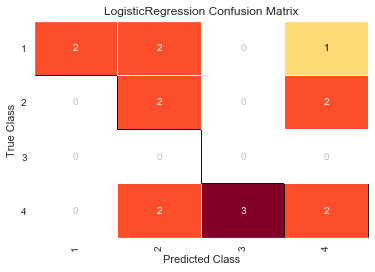

-------------------------- K Nearest Neighbors ----------------------------


The training accuracy is: 0.4918032786885246


The testing accuracy is: 0.4375


-------Classification Report--------
              precision    recall  f1-score   support

           1       0.43      0.60      0.50         5
           2       0.33      0.50      0.40         4
           3       0.00      0.00      0.00         0
           4       0.67      0.29      0.40         7

   micro avg       0.44      0.44      0.44        16
   macro avg       0.36      0.35      0.33        16
weighted avg       0.51      0.44      0.43        16

-------Confusion Matrix--------


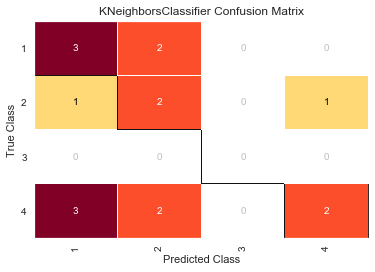

-------------------------- Decision Tree ----------------------------


The training accuracy is: 0.9836065573770492


The testing accuracy is: 0.375


-------Classification Report--------
              precision    recall  f1-score   support

           1       0.40      0.40      0.40         5
           2       0.25      0.25      0.25         4
           3       0.00      0.00      0.00         0
           4       0.43      0.43      0.43         7

   micro avg       0.38      0.38      0.38        16
   macro avg       0.27      0.27      0.27        16
weighted avg       0.38      0.38      0.38        16

-------Confusion Matrix--------


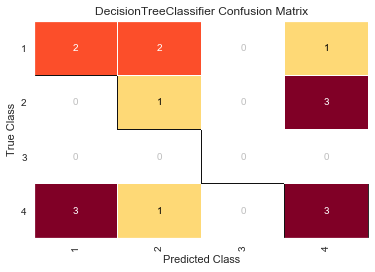

-------------------------- Random Forest ----------------------------


The training accuracy is: 0.9836065573770492


The testing accuracy is: 0.25


-------Classification Report--------
              precision    recall  f1-score   support

           1       0.50      0.20      0.29         5
           2       0.14      0.25      0.18         4
           3       0.00      0.00      0.00         0
           4       0.40      0.29      0.33         7

    accuracy                           0.25        16
   macro avg       0.26      0.18      0.20        16
weighted avg       0.37      0.25      0.28        16

-------Confusion Matrix--------


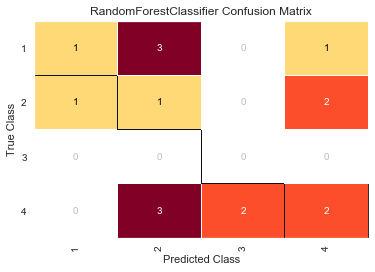

-------------------------- XGBoost ----------------------------


The training accuracy is: 0.9672131147540983


The testing accuracy is: 0.3125


-------Classification Report--------
              precision    recall  f1-score   support

           1       0.40      0.40      0.40         5
           2       0.25      0.25      0.25         4
           3       0.00      0.00      0.00         0
           4       0.33      0.29      0.31         7

    accuracy                           0.31        16
   macro avg       0.25      0.23      0.24        16
weighted avg       0.33      0.31      0.32        16

-------Confusion Matrix--------


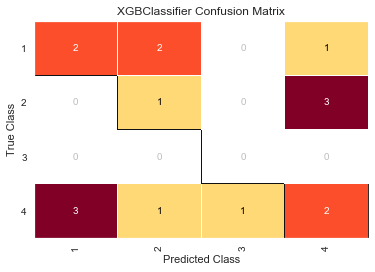

In [21]:
pipelines(X, y, 42, .20)

## Feature Selection Cont'd and Hyperparameter Tuning

There are definitely some problems going on here. First, there is some obvious overfittig happening as evidence by the huge drop in accuracy between testing/training. 

In [22]:
len(nfl_feats)

32

There are 32 features in total. Let's try iterating through our pipelines with various numbers of features. I'll start with fewer and add features (in order of importance) from there. To hone in on the performance aspects we're focusing on here I'm going to modify our pipeline definition just a tad. 

In [23]:
Models = [LR, KNN, DTree, RF, XGB]
Model_Names = ['Logistic Regression','K Nearest Neighbors','Decision Tree','Random Forest', 'XGBoost']

def pipelines_compare(X, y, random_state, test_size):
    
    #train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=test_size)
    
    #Fit/Predict models
    for model, name in zip(Models, Model_Names):
        #fitting
        model.fit(X_train, y_train)
        #predicting
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)
        training_accuracy = accuracy_score(y_train, train_preds)
        testing_accuracy = accuracy_score(y_test, test_preds)
        #printing results
        print('--------------------------', name,'----------------------------')
        print('\n')
        print('Training Accuracy:', training_accuracy, 'Testing Accuracy', testing_accuracy)
        print(classification_report(y_test, test_preds, labels=[1,2,3,4]))

In [24]:
num_feats = [5,10,20,30]

#loop which iterates through pipelines w/ increasing # of features
for num in num_feats:
    print(num,'features')
    print('\n')
    X2 = X[nfl_feats[:num]]
    y = y
    pipelines_compare(X2, y, 42, .20)
    print('\n')

5 features


-------------------------- Logistic Regression ----------------------------


Training Accuracy: 0.47540983606557374 Testing Accuracy 0.3125
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.31      1.00      0.47         4
           3       0.00      0.00      0.00         0
           4       0.50      0.14      0.22         7

    accuracy                           0.31        16
   macro avg       0.20      0.29      0.17        16
weighted avg       0.30      0.31      0.21        16

-------------------------- K Nearest Neighbors ----------------------------


Training Accuracy: 0.4918032786885246 Testing Accuracy 0.4375
              precision    recall  f1-score   support

           1       1.00      0.20      0.33         5
           2       0.33      1.00      0.50         4
           3       0.00      0.00      0.00         0
           4       0.67      0.29      0.40         7


-------------------------- XGBoost ----------------------------


Training Accuracy: 0.9672131147540983 Testing Accuracy 0.3125
              precision    recall  f1-score   support

           1       0.40      0.40      0.40         5
           2       0.25      0.25      0.25         4
           3       0.00      0.00      0.00         0
           4       0.33      0.29      0.31         7

    accuracy                           0.31        16
   macro avg       0.25      0.23      0.24        16
weighted avg       0.33      0.31      0.32        16





Hmm, some better results but still nothing that's getting me really excited (although most of these are better than our baseline accuracy of 29%). Let's try adding a grid search feature to the Decision Tree and Random Forests.

In [25]:
#grid parameters
grid1 = {
    'dtree__criterion': ['gini', 'entropy'],
    'dtree__max_depth': [None, 2, 3, 4, 5, 6],
    'dtree__min_samples_split': [2, 5, 10],
    'dtree__min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

grid2 = {
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_depth': [None, 2, 3, 4, 5, 6],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

grid3 = {
    'xgb__max_depth': [1, 2, 3, 4, 5, 6],
}

#gridsearch functions

gridsearch_DTree = GridSearchCV(estimator=DTree, 
                          param_grid=grid1, 
                          scoring='accuracy', 
                          cv=5)

gridsearch_RF = GridSearchCV(estimator=RF, 
                          param_grid=grid2, 
                          scoring='accuracy', 
                          cv=5)

gridsearch_XGB = GridSearchCV(estimator=XGB, 
                          param_grid=grid3, 
                          scoring='accuracy', 
                          cv=5)

In [26]:
Models = [LR, KNN, gridsearch_DTree, gridsearch_RF, gridsearch_XGB]
Model_Names = ['Logistic Regression','K Nearest Neighbors','Decision Tree','Random Forest','XGB']

def pipelines_compare_grid(X, y, random_state, test_size):
    
    #train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=test_size)
    
    #Fit/Predict models
    for model, name in zip(Models, Model_Names):
        #fitting
        model.fit(X_train, y_train)
        #predicting
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)
        training_accuracy = accuracy_score(y_train, train_preds)
        testing_accuracy = accuracy_score(y_test, test_preds)
        #printing results
        print('--------------------------', name,'----------------------------')
        print('\n')
        print('Training Accuracy:', training_accuracy, 'Testing Accuracy', testing_accuracy)
        print(classification_report(y_test, test_preds, labels=[1,2,3,4]))

In [27]:
num_feats = [5,10,20,30]

#loop iterating thru pipelines w/ increasing # of features 
for num in num_feats:
    print(num,'features')
    print('\n')
    X2 = X[nfl_feats[:num]]
    y = y
    pipelines_compare_grid(X2, y, 42, .20)
    print('\n')

5 features


-------------------------- Logistic Regression ----------------------------


Training Accuracy: 0.47540983606557374 Testing Accuracy 0.3125
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.31      1.00      0.47         4
           3       0.00      0.00      0.00         0
           4       0.50      0.14      0.22         7

    accuracy                           0.31        16
   macro avg       0.20      0.29      0.17        16
weighted avg       0.30      0.31      0.21        16

-------------------------- K Nearest Neighbors ----------------------------


Training Accuracy: 0.4918032786885246 Testing Accuracy 0.4375
              precision    recall  f1-score   support

           1       1.00      0.20      0.33         5
           2       0.33      1.00      0.50         4
           3       0.00      0.00      0.00         0
           4       0.67      0.29      0.40         7


-------------------------- Decision Tree ----------------------------


Training Accuracy: 0.5737704918032787 Testing Accuracy 0.3125
              precision    recall  f1-score   support

           1       0.60      0.60      0.60         5
           2       0.33      0.25      0.29         4
           3       0.00      0.00      0.00         0
           4       0.25      0.14      0.18         7

    accuracy                           0.31        16
   macro avg       0.30      0.25      0.27        16
weighted avg       0.38      0.31      0.34        16

-------------------------- Random Forest ----------------------------


Training Accuracy: 0.45901639344262296 Testing Accuracy 0.1875
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.21      0.75      0.33         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         7

   micro avg       0.19 

KNN is giving us our highest F1 score of .44 with both 5 and 30 features. Let's use our final model w/ 5 features so it is more easily explainable. 

In [34]:
y.value_counts(normalize=True)

2    0.376623
4    0.311688
1    0.220779
3    0.090909
Name: days_missed, dtype: float64

## Final Model

For the sake of clarity and cleanliness, the below section will reiterate the final model.

In [29]:
#train test split with new X. 
X3 = X[nfl_feats[:5]]

X_train, X_test, y_train, y_test = train_test_split(X3, y, random_state=42, test_size=.2)

In [30]:
#A reminder of what our top 30 features are 
nfl_feats[:5]

Index(['BodyPart_Foot', 'BodyPart_Knee', 'FieldType_Natural',
       'PositionGroup_LB', 'BodyPart_Ankle'],
      dtype='object')

The training accuracy is: 0.4918032786885246


The testing accuracy is: 0.4375


-------Classification Report--------
              precision    recall  f1-score   support

           1       1.00      0.20      0.33         5
           2       0.33      1.00      0.50         4
           3       0.00      0.00      0.00         0
           4       0.67      0.29      0.40         7

   micro avg       0.44      0.44      0.44        16
   macro avg       0.50      0.37      0.31        16
weighted avg       0.69      0.44      0.40        16

-------Confusion Matrix--------


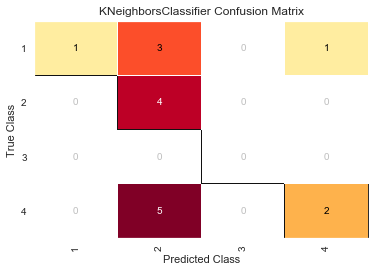

In [31]:
#fit
KNN.fit(X_train, y_train)
#predict
pred_train = KNN.predict(X_train)
pred_test = KNN.predict(X_test)
training_acc = accuracy_score(y_train, pred_train)
testing_acc = accuracy_score(y_test, pred_test)
#confusion matrix
cm = ConfusionMatrix(KNN)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
#printing results
print('The training accuracy is:', training_acc)
print('\n')
print('The testing accuracy is:', testing_acc)
print('\n')
print('-------Classification Report--------')
print(classification_report(y_test, pred_test, labels=[1,2,3,4]))
print('-------Confusion Matrix--------')
cm.show() 

Our final model still isn't performing superbly, however it did improve our chances of predicting days missed by 10% than random guessing. It's not perfect but it's improved!

## Predicting Days Missed With Our Model

Let's try out the model! Input information concerning a player injury below and see how many days our model predicts he might miss!

In [32]:
def predict():
    #gather new info
    new_data = []
    print('Please answer the below yes or no questions. Please answer 0 for no and 1 for yes.')
    print('\n')
    foot = input('Is the injury to the foot?')
    new_data.append(foot)
    knee = input('Is the injury to the knee?')
    new_data.append(knee)
    natural = input('Was the field a grass field?')
    new_data.append(natural)
    LB = input('Was the player a linebacker?')
    new_data.append(LB)
    ankle = input('Is the injury to the ankle?')
    new_data.append(ankle)
    
    #put info in correct shape
    new_data = list(map(int, new_data))
    new_data = np.array(new_data)
    new_data = new_data.reshape(1,-1)
    
    #predict 
    prediction = KNN.predict(new_data)
    print('\n')
    print('\n')
    
    #printing prediction
    for x in prediction:
        if x==1: 
            print('The player will likely miss one week or less.')
        elif x==2: 
            print('The player will likely miss one to three weeks.')
        elif x==3: 
            print('The player will likely miss three week to two months.')
        else: 
            print('The player will likely miss 2 or more months.')
    
    

In [33]:
predict()

Please answer the below yes or no questions. Please answer 0 for no and 1 for yes.


Is the injury to the foot?0
Is the injury to the knee?0
Was the field a grass field?1
Was the player a linebacker?1
Is the injury to the ankle?1




The player will likely miss one week or less.


In [35]:
y.value_counts(normalize=True)

2    0.376623
4    0.311688
1    0.220779
3    0.090909
Name: days_missed, dtype: float64

## Final Comments

While this was an interesting and thought provoking project, the dataset left me wishing for more. Less extraneous information and more information regarding the actual injuries (more specifics, upper body injuries), as well as other information regarding the time in the game/season it occured etc. The data set was also quite small and would likely perform with improved accuracy. 